## CS310 Natural Language Processing
## Assignment 1. Neural Text Classification

**Total points**: 50

You should roughtly follow the structure of the notebook. Add additional cells if you feel needed. 

You can (and you should) re-use the code from Lab 2. 

Make sure your code is readable and well-structured.

### 0. Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_recall_fscore_support

### 1. Data Processing

In [2]:

# 基本字符级别分词器
class BasicTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):
        # 只保留中文字符
        chinese_chars = re.findall(r'[\u4e00-\u9fff]', text)
        return chinese_chars

# 改进的分词器
class ImprovedTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):
        tokens = []
        # 匹配中文字符、连续数字、英文单词和标点符号
        pattern = r'[\u4e00-\u9fff]|[0-9]+|[a-zA-Z]+|[^\w\s]'
        matches = re.finditer(pattern, text)
        for match in matches:
            tokens.append(match.group(0))
        return tokens

# 自定义数据集类
class HumorDataset(Dataset):
    def __init__(self, file_path, tokenizer, vocab=None, max_len=100):
        self.data = []
        self.labels = []
        self.tokenizer = tokenizer
        self.max_len = max_len
        
        # 读取jsonl文件
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                item = json.loads(line)
                tokens = self.tokenizer.tokenize(item['sentence'])
                self.data.append(tokens)
                self.labels.append(item['label'][0])
        
        # 构建词汇表
        if vocab is None:
            self.vocab = {'<PAD>': 0, '<UNK>': 1}
            token_counter = Counter()
            for tokens in self.data:
                token_counter.update(tokens)
            
            # 添加频率大于1的词到词汇表
            for token, count in token_counter.items():
                if count > 1:
                    self.vocab[token] = len(self.vocab)
        else:
            self.vocab = vocab
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        tokens = self.data[idx]
        label = self.labels[idx]
        
        # 将token转换为索引
        indices = []
        for token in tokens[:self.max_len]:
            if token in self.vocab:
                indices.append(self.vocab[token])
            else:
                indices.append(self.vocab['<UNK>'])
        
        # 填充序列
        if len(indices) < self.max_len:
            indices += [self.vocab['<PAD>']] * (self.max_len - len(indices))
        
        return {
            'input_ids': torch.tensor(indices, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }
    
    def get_vocab(self):
        return self.vocab

# 加载数据
def load_data(train_path, test_path, tokenizer_type='improved', batch_size=32):
    if tokenizer_type == 'basic':
        tokenizer = BasicTokenizer()
    else:
        tokenizer = ImprovedTokenizer()
    
    # 加载训练集并构建词汇表
    train_dataset = HumorDataset(train_path, tokenizer)
    vocab = train_dataset.get_vocab()
    
    # 加载测试集，使用训练集的词汇表
    test_dataset = HumorDataset(test_path, tokenizer, vocab=vocab)
    
    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    return train_loader, test_loader, vocab

### 2. Build the Model

In [5]:

class HumorClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dims=[256, 128], num_classes=2):
        super(HumorClassifier, self).__init__()
        
        # 使用EmbeddingBag实现词袋模型
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, mode='mean')
        
        # 构建至少2个隐藏层的全连接网络
        layers = []
        input_dim = embed_dim
        
        # 添加隐藏层
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))  # 添加dropout防止过拟合
            input_dim = hidden_dim
        
        # 添加输出层
        layers.append(nn.Linear(input_dim, num_classes))
        
        # 使用Sequential模块组合所有层
        self.fc_layers = nn.Sequential(*layers)
        
        # 初始化权重
        self.init_weights()
    
    def init_weights(self):
        # 初始化嵌入层
        nn.init.xavier_uniform_(self.embedding.weight)
        
        # 初始化全连接层
        for layer in self.fc_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)
    
    def forward(self, text, offsets=None):
        # 如果没有提供offsets，则假设每个样本是单独的序列
        if offsets is None:
            # 创建offsets，每个样本的起始位置
            batch_size = text.size(0)
            offsets = torch.arange(0, batch_size, dtype=torch.long, device=text.device) * text.size(1)
        
        # 通过嵌入层获取文本表示
        embedded = self.embedding(text.view(-1), offsets)
        
        # 通过全连接层
        output = self.fc_layers(embedded)
        
        return output

### 3. Train and Evaluate

使用设备: cpu


/Users/sco/miniconda3/envs/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/90, Loss: 0.6044, Train Acc: 0.7053, Test Acc: 0.7389
Precision: 0.5459, Recall: 0.7389, F1: 0.6279
Epoch 2/90, Loss: 0.5720, Train Acc: 0.7169, Test Acc: 0.7404
Precision: 0.6892, Recall: 0.7404, F1: 0.6587
Epoch 3/90, Loss: 0.5356, Train Acc: 0.7388, Test Acc: 0.7327
Precision: 0.7058, Recall: 0.7327, F1: 0.7128
Epoch 4/90, Loss: 0.5155, Train Acc: 0.7516, Test Acc: 0.7419
Precision: 0.7118, Recall: 0.7419, F1: 0.7163
Epoch 5/90, Loss: 0.5048, Train Acc: 0.7634, Test Acc: 0.6851
Precision: 0.7051, Recall: 0.6851, F1: 0.6934
Epoch 6/90, Loss: 0.4938, Train Acc: 0.7698, Test Acc: 0.7281
Precision: 0.7007, Recall: 0.7281, F1: 0.7083
Epoch 7/90, Loss: 0.4814, Train Acc: 0.7789, Test Acc: 0.7327
Precision: 0.7032, Recall: 0.7327, F1: 0.7101
Epoch 8/90, Loss: 0.4688, Train Acc: 0.7854, Test Acc: 0.7389
Precision: 0.7070, Recall: 0.7389, F1: 0.7119
Epoch 9/90, Loss: 0.4639, Train Acc: 0.7838, Test Acc: 0.7174
Precision: 0.7047, Recall: 0.7174, F1: 0.7101
Epoch 10/90, Loss: 0.4486, T

/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_28675/1407472014.py:150: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_28675/1407472014.py:150: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_28675/1407472014.py:150: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_28675/1407472014.py:150: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/ipykernel_28675/1407472014.py:150: UserWarning: Glyph 20934 (\N{CJK UNIFIED IDEOGRAPH-51C6}) missing from current font.
  plt.tight_layout()
/var/folders/_4/v6wmn5j14xb7tmgnzj8yt_4c0000gn/T/i

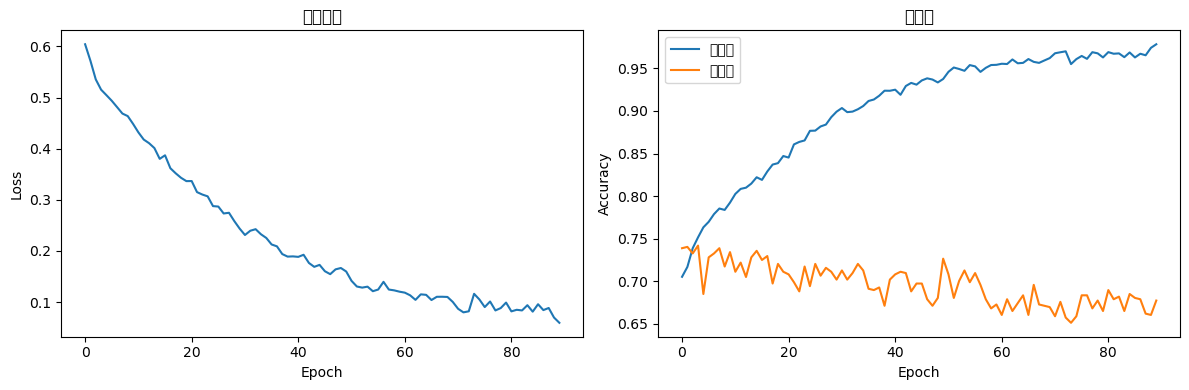


最终测试结果:
准确率: 0.6774
精确率: 0.6774
召回率: 0.6774
F1分数: 0.6774


In [6]:
def train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device='cpu'):
    # 将模型移至指定设备
    model = model.to(device)
    
    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # 记录训练过程
    train_losses = []
    train_accs = []
    test_accs = []
    
    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch in train_loader:
            # 获取数据并移至设备
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            # 清零梯度
            optimizer.zero_grad()
            
            # 前向传播
            outputs = model(inputs)
            
            # 计算损失
            loss = criterion(outputs, labels)
            
            # 反向传播和优化
            loss.backward()
            optimizer.step()
            
            # 统计
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        # 计算训练集准确率
        train_loss = total_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # 在测试集上评估
        test_acc, test_metrics = evaluate_model(model, test_loader, device)
        test_accs.append(test_acc)
        
        # 打印训练信息
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')
        print(f'Precision: {test_metrics["precision"]:.4f}, Recall: {test_metrics["recall"]:.4f}, F1: {test_metrics["f1"]:.4f}')
    
    # 返回训练历史和最终测试指标
    history = {
        'train_loss': train_losses,
        'train_acc': train_accs,
        'test_acc': test_accs
    }
    
    return history, test_metrics

def evaluate_model(model, data_loader, device='cpu'):
    model.eval()
    total_correct = 0
    total_count = 0
    y_labels = []
    y_preds = []
    
    with torch.no_grad():
        for batch in data_loader:
            # 获取数据并移至设备
            inputs = batch['input_ids'].to(device)
            labels = batch['label'].to(device)
            
            # 前向传播
            outputs = model(inputs)
            
            # 获取预测结果
            predictions = outputs.argmax(1)
            
            # 统计
            total_correct += (predictions == labels).sum().item()
            total_count += labels.size(0)
            
            # 收集所有预测和标签用于计算指标
            y_labels.extend(labels.cpu().numpy())
            y_preds.extend(predictions.cpu().numpy())
    
    # 计算准确率
    accuracy = total_correct / total_count
    
    # 使用sklearn计算精确率、召回率和F1分数
    precision, recall, f1, _ = precision_recall_fscore_support(y_labels, y_preds, average='weighted')
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    
    return accuracy, metrics

def calculate_metrics(y_true, y_pred):
    # 计算TP, FP, TN, FN
    tp = sum((y_pred == 1) & (np.array(y_true) == 1))
    fp = sum((y_pred == 1) & (np.array(y_true) == 0))
    tn = sum((y_pred == 0) & (np.array(y_true) == 0))
    fn = sum((y_pred == 0) & (np.array(y_true) == 1))
    
    # 计算精确率
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # 计算召回率
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # 计算F1分数
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    
    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'])
    plt.title('训练损失')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='训练集')
    plt.plot(history['test_acc'], label='测试集')
    plt.title('准确率')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# 示例：如何使用训练和评估函数
def run_experiment(train_path, test_path, tokenizer_type='improved', batch_size=256, 
                  embed_dim=128, hidden_dims=[256, 128], epochs=90, lr=0.003):
    # 加载数据
    train_loader, test_loader, vocab = load_data(train_path, test_path, tokenizer_type, batch_size)
    
    # 创建模型
    vocab_size = len(vocab)
    model = HumorClassifier(vocab_size, embed_dim, hidden_dims)
    
    # 检测是否有GPU可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # 训练模型
    history, final_metrics = train_model(model, train_loader, test_loader, epochs, lr, device)
    
    # 绘制训练历史
    plot_training_history(history)
    
    # 打印最终结果
    print("\n最终测试结果:")
    print(f"准确率: {history['test_acc'][-1]:.4f}")
    print(f"精确率: {final_metrics['precision']:.4f}")
    print(f"召回率: {final_metrics['recall']:.4f}")
    print(f"F1分数: {final_metrics['f1']:.4f}")
    
    return model, history, final_metrics

model, history, metrics = run_experiment('train.jsonl', 'test.jsonl')

### 4. Explore Word Segmentation

In [7]:
import jieba

# 使用jieba分词器的分词器
class JiebaTokenizer:
    def __init__(self):
        pass
    
    def tokenize(self, text):
        # 使用jieba进行中文分词
        words = jieba.cut(text, cut_all=False)
        return list(words)

# 比较不同分词方法的性能
def compare_tokenizers(train_path, test_path, batch_size=256, embed_dim=128, 
                       hidden_dims=[128, 64], epochs=90, lr=0.0005):
    results = {}
    
    # 测试基本字符级分词器
    print("使用基本字符级分词器...")
    model_char, history_char, metrics_char = run_experiment(
        train_path, test_path, tokenizer_type='basic', 
        batch_size=batch_size, embed_dim=embed_dim, 
        hidden_dims=hidden_dims, epochs=epochs, lr=lr
    )
    results['字符级'] = {
        'accuracy': history_char['test_acc'][-1],
        'precision': metrics_char['precision'],
        'recall': metrics_char['recall'],
        'f1': metrics_char['f1'],
        'vocab_size': len(model_char.embedding.weight)
    }
    
    # 测试改进的分词器
    print("\n使用改进的分词器...")
    model_improved, history_improved, metrics_improved = run_experiment(
        train_path, test_path, tokenizer_type='improved', 
        batch_size=batch_size, embed_dim=embed_dim, 
        hidden_dims=hidden_dims, epochs=epochs, lr=lr
    )
    results['改进的'] = {
        'accuracy': history_improved['test_acc'][-1],
        'precision': metrics_improved['precision'],
        'recall': metrics_improved['recall'],
        'f1': metrics_improved['f1'],
        'vocab_size': len(model_improved.embedding.weight)
    }
    
    # 测试jieba分词器
    print("\n使用jieba分词器...")
    # 修改load_data函数以支持jieba分词器
    def load_data_jieba(train_path, test_path, batch_size=32):
        tokenizer = JiebaTokenizer()
        
        # 加载训练集并构建词汇表
        train_dataset = HumorDataset(train_path, tokenizer)
        vocab = train_dataset.get_vocab()
        
        # 加载测试集，使用训练集的词汇表
        test_dataset = HumorDataset(test_path, tokenizer, vocab=vocab)
        
        # 创建数据加载器
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)
        
        return train_loader, test_loader, vocab
    
    # 加载数据
    train_loader, test_loader, vocab = load_data_jieba(train_path, test_path, batch_size)
    
    # 创建模型
    vocab_size = len(vocab)
    model = HumorClassifier(vocab_size, embed_dim, hidden_dims)
    
    # 检测是否有GPU可用
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    print(f"词汇表大小: {vocab_size}")
    
    # 增加类别权重
    class_weights = torch.tensor([1.0, 5.0], device=device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    # 训练模型
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    history_jieba, metrics_jieba = train_model(
        model, train_loader, test_loader, epochs, 
        optimizer, criterion, None, device
    )
    
    results['jieba'] = {
        'accuracy': history_jieba['test_acc'][-1],
        'precision': metrics_jieba['precision'],
        'recall': metrics_jieba['recall'],
        'f1': metrics_jieba['f1'],
        'vocab_size': vocab_size
    }
    
    # 比较结果
    print("\n分词方法比较结果:")
    print(f"{'分词方法':<10} {'词汇表大小':<10} {'准确率':<10} {'精确率':<10} {'召回率':<10} {'F1分数':<10}")
    print("-" * 60)
    for method, metrics in results.items():
        print(f"{method:<10} {metrics['vocab_size']:<10} {metrics['accuracy']:.4f}     {metrics['precision']:.4f}     {metrics['recall']:.4f}     {metrics['f1']:.4f}")
    
    # 绘制比较图
    plt.figure(figsize=(10, 6))
    methods = list(results.keys())
    accuracies = [results[m]['accuracy'] for m in methods]
    f1_scores = [results[m]['f1'] for m in methods]
    
    x = np.arange(len(methods))
    width = 0.35
    
    plt.bar(x - width/2, accuracies, width, label='准确率')
    plt.bar(x + width/2, f1_scores, width, label='F1分数')
    
    plt.xlabel('分词方法')
    plt.ylabel('分数')
    plt.title('不同分词方法的性能比较')
    plt.xticks(x, methods)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return results

# 运行比较实验
results = compare_tokenizers('train.jsonl', 'test.jsonl')

ModuleNotFoundError: No module named 'jieba'